In [1]:
import matplotlib.pyplot as plt

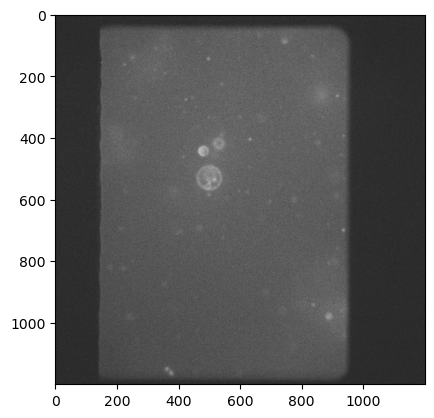

In [30]:
# Load GUV image we are going to use for the psf
image = plt.imread('GUVs_4chol_brick011_405 nm.tif')

# Display the image
plt.imshow(image, cmap=plt.cm.gray)
plt.show()


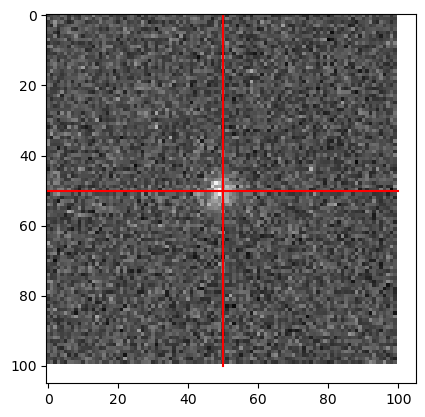

In [40]:
y_center = 405
x_center = 633

psf_image = image[y_center - 50:y_center + 50, x_center - 50:x_center + 50]

plt.imshow(psf_image, cmap=plt.cm.gray)
plt.plot([50, 50], [0, 100], 'r-')
plt.plot([0, 100], [50, 50], 'r-')
plt.show()

In [44]:
print(psf_image)

[[124 126 129 ... 131 121 129]
 [139 124 129 ... 125 123 123]
 [122 133 146 ... 126 119 126]
 ...
 [123 134 132 ... 117 123 128]
 [126 125 122 ... 132 119 115]
 [128 135 118 ... 126 124 130]]


In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_thresholded_points(image, threshold):
    # Create a binary mask based on the threshold
    mask = image > threshold
    
    # Get the coordinates of the points above the threshold
    y_coords, x_coords = np.where(mask)
    
    # Plot the image
    plt.imshow(image, cmap=plt.cm.gray)
    
    # Plot the thresholded points
    plt.scatter(x_coords, y_coords, color='red', marker='.')
    
    # Show the plot
    plt.show()


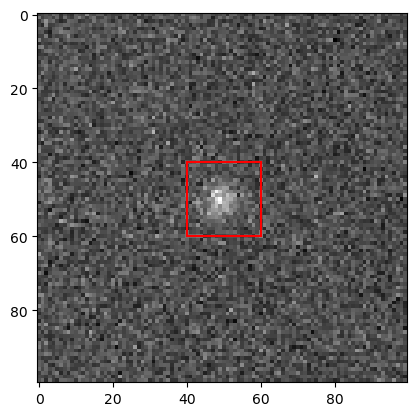

In [83]:
y_spread = 10
x_spread = 10

plt.imshow(psf_image, cmap=plt.cm.gray)
plt.plot([50-x_spread, x_spread+50], [50-y_spread, 50-y_spread], 'r-')
plt.plot([50-x_spread, x_spread+50], [50+y_spread, 50+y_spread], 'r-')
plt.plot([50-x_spread, 50-x_spread], [50-y_spread, y_spread+50], 'r-')
plt.plot([50+x_spread, 50+x_spread], [50-y_spread, y_spread+50], 'r-')
plt.show()

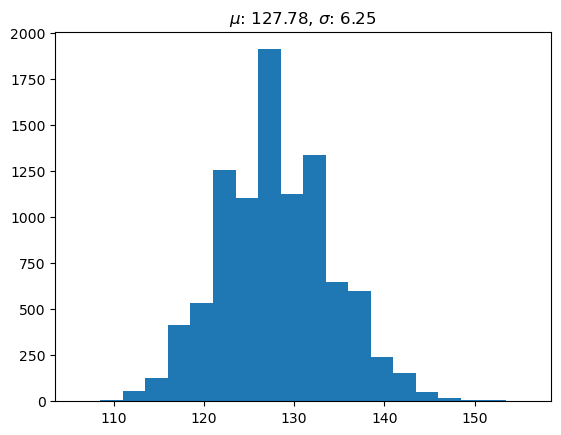

In [96]:
background_distribution = list(psf_image.flatten()) #flatten all pixels into one list
for row in psf_image[50-y_spread:50+y_spread]: #for row that has pixels in the box
    for pixel in row[50-x_spread:50+x_spread]: #for pixel in the box
        background_distribution.remove(pixel) #remove one instance of that pixel value form the distribution

mean = np.mean(background_distribution)
sig = np.std(background_distribution)

plt.hist(background_distribution, bins=20)
plt.title(f'$\mu$: {mean:.2f}, $\sigma$: {sig:.2f}')
plt.show()

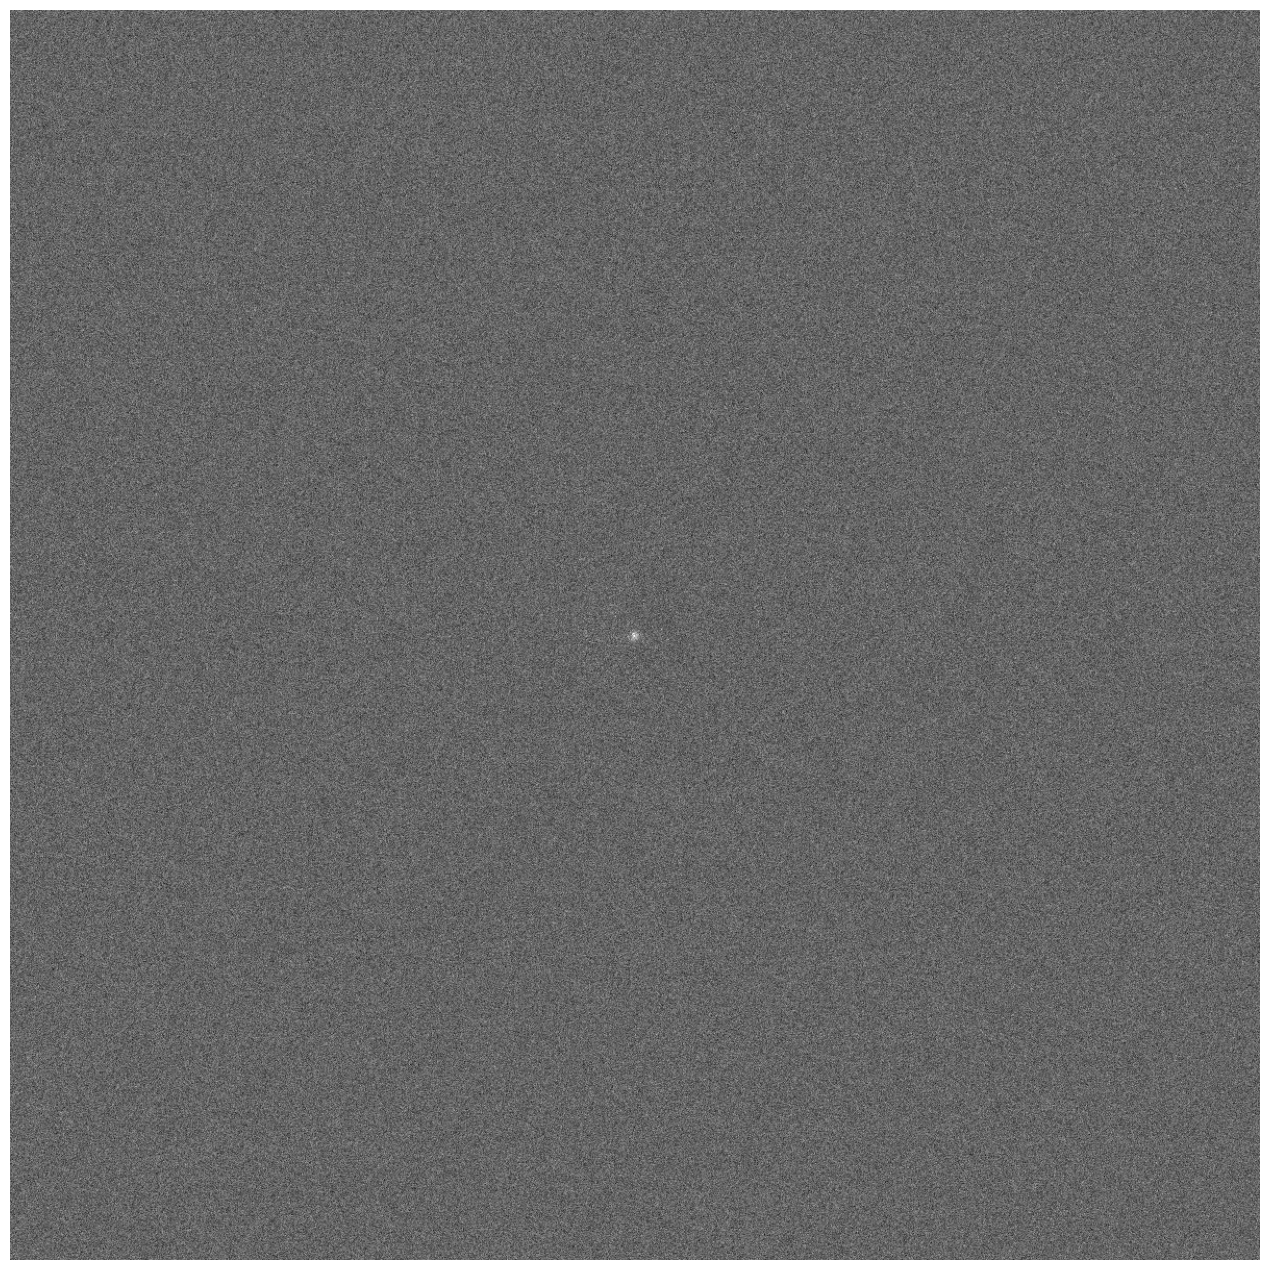

In [141]:
wf_psf_image = np.zeros((1200,1200)) #make an empty image
for i in range(1200): #for each row
    for j in range(1200): #for each column
        wf_psf_image[i,j] = np.random.normal(mean, sig) #fill the image with random numbers from the distribution
wf_psf_image[600 - 50: 600 + 50,600 - 50:600 +50] = psf_image #replace the center of the image with the original cropped psf

dpi = 96
inch_per_pixel = 1/dpi

fig = plt.figure(frameon=False)
fig.set_size_inches(1200*inch_per_pixel, 1200*inch_per_pixel)

ax = plt.Axes(fig, [0,0,1,1])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(wf_psf_image, aspect = 'auto', cmap='gray')
plt.savefig('wf_psf_image.png', dpi=dpi)
plt.show()

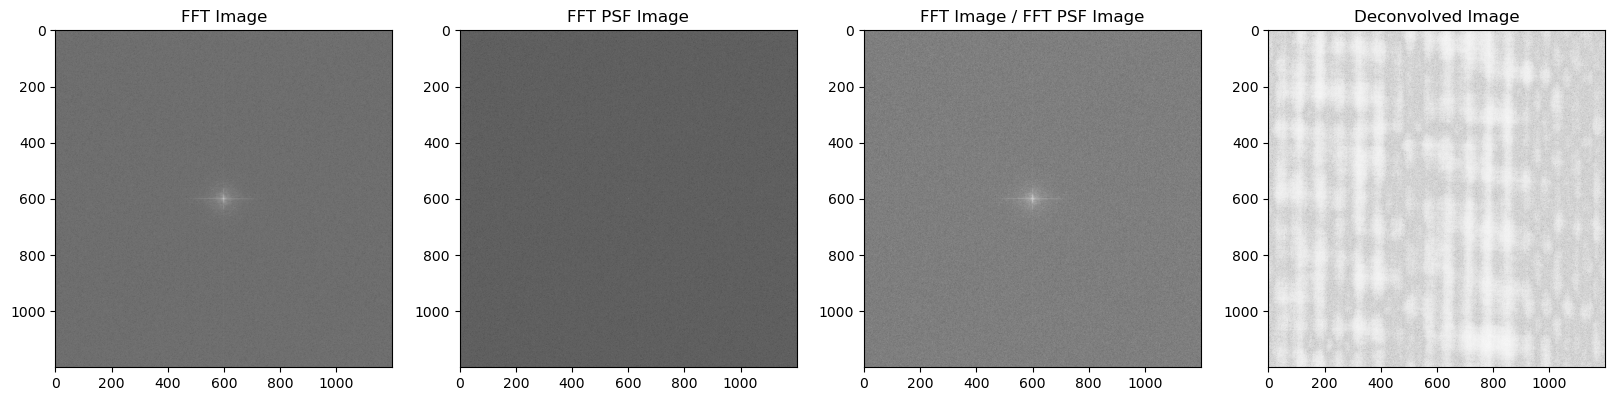

In [138]:
fft_image = np.fft.fft2(image)
fft_psf_image = np.fft.fft2(wf_psf_image)
division = fft_image/fft_psf_image
deconvolved_image = np.fft.ifft2(division)

fig, axs = plt.subplots(1,4, figsize=(20, 5))
axs[0].imshow(np.log(np.abs(np.fft.fftshift(fft_image))), cmap=plt.cm.gray)
axs[0].set_title('FFT Image')

axs[1].imshow(np.log(np.abs(np.fft.fftshift(fft_psf_image))), cmap=plt.cm.gray)
axs[1].set_title('FFT PSF Image')

axs[2].imshow(np.log(np.abs(np.fft.fftshift(division))), cmap=plt.cm.gray)
axs[2].set_title('FFT Image / FFT PSF Image')

axs[3].imshow(np.log(np.abs(np.fft.fftshift(deconvolved_image))), cmap=plt.cm.gray)
axs[3].set_title('Deconvolved Image')
plt.show()